In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import os

from joblib import Parallel, delayed

from utils import get_mean_tag, plot_ages, get_experiment_combinations, run_experiment

In [2]:
run_dir = './test'                                 # directory that all logs/outputs are saved to
n_repetitions = 5 # 30                             # number of runs per hyper-parameter combination
total_timesteps = 200_000 #1_000_000 # 100_000_000          # number of timesteps per run
n_jumps = 2 #10                                       # number of data distribution (change every total_timesteps//n_jumps timesteps)
n_jobs = 5                                        # number of runs to execute simultaneously. -1 to use all cores. -2 leave one core for other things

settings = {
    'policy_kwargs': {'net_arch': [{'pi': [256, 256], 'vf':[256, 256]}],    # policy and value network linear usits per layer. An additional layer is added at the end to produce a distribution over the action space
                      'activation_fn': nn.Tanh,
                      'optimizer_class': torch.optim.Adam,                  # placeholder, will internally be replaced by CBP
                      'optimizer_kwargs': {
                          'betas': (0.9, 0.999)
                      }
                     },
    'n_steps': 4096,
    'n_epochs': 10,
    'batch_size': 128,
    'gae_lambda': 0.95,
    'gamma': 0.99,
    'clip_range': 0.2,
    'learning_rate': 1e-4,
    'tensorboard_log': os.path.join(run_dir, 'tensorboard')
}

cppo_options = [                               # CBP hyper-parameter options. Will be placed into settings['policy_kwargs']['optimizer_kwargs']
    {'rho': 10**-3, 'm': int(1e2)},
    {'rho': 10**-3, 'm': int(5e2)},
    {'rho': 10**-4, 'm': int(5e3)},
    {'rho': 10**-4, 'm': int(5e2)},
    {'rho': 10**-5, 'm': int(1e4)},
    {'rho': 10**-5, 'm': int(5e4)}
]

model_dir = os.path.join(run_dir, 'models')   # directory for saving final models (for comparing final weight magnitudes?)
ages_dir = os.path.join(run_dir, 'ages')      # directory for saving unit ages. Can be used to analyze reset evolution/distrubution

eval_args = {
    'max_steps': 2500,           # prevent infinite episodes
    'n_eval_episodes': 1,         # number of episodes run for evaluation to get mean reward. SlipperyAnt with set friction is deterministic, therefore a single episode should be enough
    'deterministic': True
}

entropy = 177985092675209314376853830526676926007

In [3]:
experiments = get_experiment_combinations(n_repetitions, settings, cppo_options, total_timesteps, n_jumps, eval_args, model_dir, ages_dir, entropy)

In [4]:
jobs = list(map(lambda opt: delayed(run_experiment)(*opt), experiments))

In [5]:
_ = Parallel(n_jobs=n_jobs, verbose=10)(jobs)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 22.4min
exception calling callback for <Future at 0x1bbf02ca340 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\chris\anaconda3\lib\site-packages\joblib\parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\chris\anaconda3\lib\site-packages\joblib\parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\chris\anaconda3\lib\site-packages\joblib\parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\chris\anaconda3\lib\site-packages\joblib\parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\chris\an

KeyboardInterrupt: 

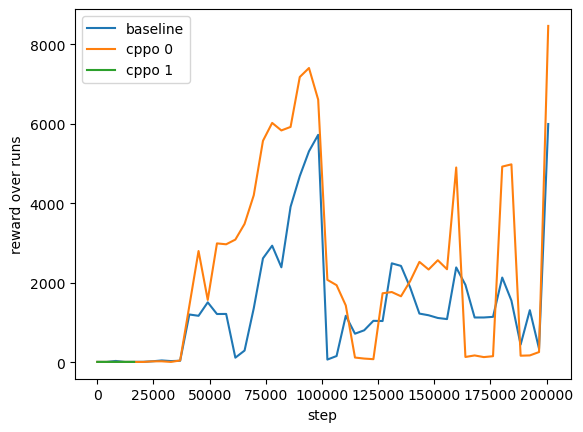

In [3]:
get_mean_tag('eval/mean_reward', settings['tensorboard_log']).plot()
plt.ylabel('reward over runs')
plt.show()

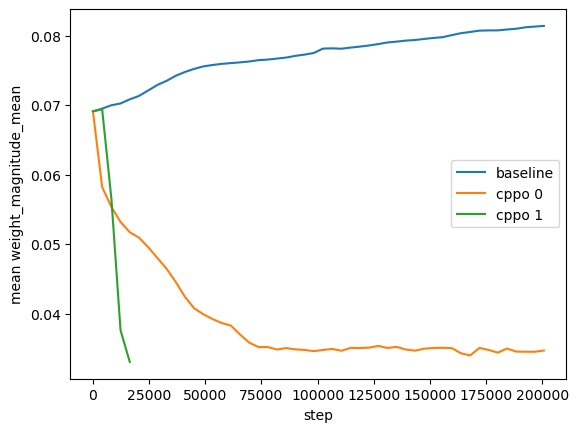

In [4]:
get_mean_tag('train/weight_magnitude_mean', settings['tensorboard_log']).plot()
plt.ylabel('mean weight_magnitude_mean')
plt.show()

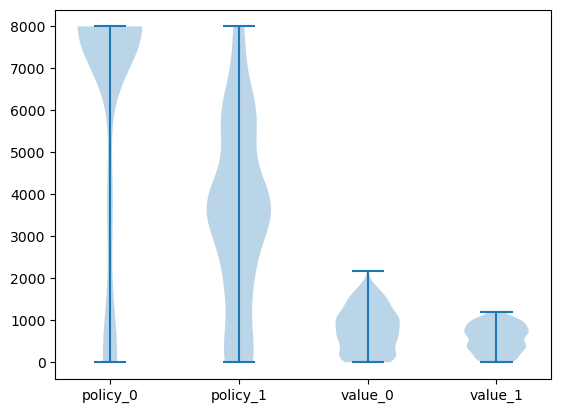

In [5]:
plot_ages(ages_dir, 'cppo 0_1', 25) # above 300 after 1 step because data is handled in batches and multiple iterations of the data are done.

In [ ]:
# TODO
# add hyperparameter logging